some text

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import xml.etree.ElementTree
import os,glob,sys
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
import sys
sys.path.append('../..')

In [5]:
from vimms.PythonMzmine import *
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController,ExcludingTopNController
from vimms.PythonMzmine import *

In [6]:
from vimms.Roi import make_roi, RoiToChemicalCreator
from vimms.BOMAS import *
from vimms.Common import *
from vimms.Environment import *
from pathlib import Path
from vimms.PlotsForPaper import get_frag_events

In [7]:
from vimms.DataGenerator import extract_hmdb_metabolite, get_data_source, get_spectral_feature_database

In [8]:
set_log_level_warning()

# Load files needed to run experiments

In [9]:
data_dir = os.path.join(os.path.abspath(os.path.join(os.path.join(os.getcwd(),".."),"..")),'tests','integration','fixtures')
ps = load_obj(Path(data_dir,'peak_sampler_mz_rt_int_beerqcb_fragmentation.p'))

In [10]:
MZML2CHEMS_DICT = {'min_ms1_intensity': 0,
                  'mz_tol': 5,
                  'mz_units':'ppm',
                  'min_length':1,
                  'min_intensity':0,
                  'start_rt':0,
                  'stop_rt':1560}

# Data

The raw files can be found below

In [11]:
QCA_seed_mzml_file = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\CLDS Metabolomics Project\\Experimental_Results\\20200715_TopN_vs_ROI\\from_controllers\\QCA\\TopN_QCA.mzML'
QCB_seed_mzml_file = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\CLDS Metabolomics Project\\Experimental_Results\\20200715_TopN_vs_ROI\\from_controllers\\QCB\\TopN_QCB.mzML'

We can convert them into the ViMMS chemicals to allow us to run the virtual MS

In [12]:
#TopN_QCA_dataset = mzml2chems(QCA_seed_mzml_file, ps, MZML2CHEMS_DICT, n_peaks=None)
#TopN_QCB_dataset = mzml2chems(QCB_seed_mzml_file, ps, MZML2CHEMS_DICT, n_peaks=None)
#save_obj(TopN_QCA_dataset, Path(os.getcwd(),'TopN_QCA_dataset.p'))
#save_obj(TopN_QCB_dataset, Path(os.getcwd(),'TopN_QCB_dataset.p'))
TopN_QCA_dataset = load_obj(Path(os.getcwd(),'TopN_QCA_dataset.p'))
TopN_QCB_dataset = load_obj(Path(os.getcwd(),'TopN_QCB_dataset.p'))

## Experiment Parameters

In [13]:
min_rt = 0
max_rt = 26*60 # entire run
min_ms1_intensity = 5000
mz_tol = 10
rt_tol = 15
N = 10

roi_time_dict = {1: 0.71,2:0.20}
topn_time_dict = {1: 0.60,2:0.20}

ionisation_mode = POSITIVE
isolation_width = 1

min_roi_intensity = 500
min_roi_length = 0
min_roi_length_for_fragmentation = 0

SmartROI parameter options

In [14]:
reset_length_seconds = 1e6 # set so reset never happens
iif_values = [2,3,5,10,1e3,1e6]
dp_values = [0,0.1,0.5,1,5]

WeighedDEW parameter options

In [15]:
t0_vals = [1,3,5,10,15,30,60]
t0_vals = [1,3,10,15,30,60]
rt_tol_vals = [15,30,60,120,240,300,360]
rt_tol_vals = [15,60,120,240,360,3600]

## Get the picked peak boxes

In [16]:
qca_peak_csv_file = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\CLDS Metabolomics Project\\Experimental_Results\\20200715_TopN_vs_ROI\\from_controllers\\QCA\\TopN_QCA_box.csv'
qcb_peak_csv_file = 'C:\\Users\\Vinny\\OneDrive - University of Glasgow\\CLDS Metabolomics Project\\Experimental_Results\\20200715_TopN_vs_ROI\\from_controllers\\QCB\\TopN_QCB_box.csv'

qca_boxes = load_picked_boxes(qca_peak_csv_file)
qcb_boxes = load_picked_boxes(qcb_peak_csv_file)

## Experiment 1 - QCA, SmartROI

In [15]:
output_folder = Path(os.getcwd(), 'experiment_1')

In [26]:
for iif in iif_values:
    for dp in dp_values:
        print(iif,dp)
        intensity_increase_factor = iif # fragment ROI again if intensity increases 10 fold
        drop_perc = dp/100

        controller = TopN_SmartRoiController(ionisation_mode, isolation_width, mz_tol, min_ms1_intensity,
                                             min_roi_intensity, min_roi_length, N = N, rt_tol = rt_tol, 
                                             min_roi_length_for_fragmentation = min_roi_length_for_fragmentation,
                                             reset_length_seconds = reset_length_seconds,
                                             intensity_increase_factor = intensity_increase_factor,
                                             drop_perc = drop_perc)

        mass_spec = IndependentMassSpectrometer(ionisation_mode, TopN_QCA_dataset,
                                                ps,
                                                add_noise=True,
                                               scan_duration_dict=roi_time_dict)

        env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
        env.run()
        
        out_name = 'SmartROI_{}_{}.mzml'.format(iif,dp)
        env.write_mzML(output_folder, out_name)

2 0


(1560.100s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.3900000001033/1560 [02:04<00:00, 12.48it/s]


2 0.1


(1560.550s) ms_level=1 N=10 DEW=15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.840000000104/1560 [02:14<00:00, 11.60it/s]


2 0.5


(1560.680s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.9700000001035/1560 [02:02<00:00, 12.73it/s]


2 1


(1560.270s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.5600000001043/1560 [02:09<00:00, 12.06it/s]


2 5


(1560.490s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.7800000001055/1560 [02:10<00:00, 11.92it/s]


3 0


(1560.490s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.7800000000902/1560 [02:14<00:00, 11.56it/s]


3 0.1


(1560.180s) ms_level=2 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.9800000000903/1560 [02:04<00:00, 12.57it/s]


3 0.5


(1560.070s) ms_level=1 N=10 DEW=15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.36000000009/1560 [02:16<00:00, 11.44it/s]


3 1


(1560.100s) ms_level=2 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.9000000000906/1560 [02:04<00:00, 12.56it/s]


3 5


(1560.310s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.6000000000922/1560 [02:16<00:00, 11.44it/s]


5 0


(1560.700s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.9900000000855/1560 [02:05<00:00, 12.40it/s]


5 0.1


(1560.680s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.9700000000857/1560 [02:19<00:00, 11.21it/s]


5 0.5


(1560.330s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.6200000000858/1560 [02:12<00:00, 11.79it/s]


5 1


(1560.180s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.4700000000862/1560 [02:12<00:00, 11.75it/s]


5 5


(1560.160s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.4500000000874/1560 [02:04<00:00, 12.49it/s]


10 0


(1560.040s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.3300000000831/1560 [02:20<00:00, 11.14it/s]


10 0.1


(1560.640s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.9300000000828/1560 [02:13<00:00, 11.66it/s]


10 0.5


(1560.380s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.6700000000835/1560 [02:14<00:00, 11.63it/s]


10 1


(1560.120s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.4100000000835/1560 [02:10<00:00, 11.92it/s]


10 5


(1560.080s) ms_level=1 N=10 DEW=15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.370000000085/1560 [02:20<00:00, 11.09it/s]


1000.0 0


(1560.480s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.7700000000707/1560 [02:16<00:00, 11.39it/s]


1000.0 0.1


(1560.460s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.7500000000707/1560 [02:17<00:00, 11.37it/s]


1000.0 0.5


(1560.570s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.8600000000708/1560 [02:15<00:00, 11.48it/s]


1000.0 1


(1560.150s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.4400000000705/1560 [02:17<00:00, 11.37it/s]


1000.0 5


(1560.590s) ms_level=1 N=10 DEW=15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.880000000071/1560 [02:15<00:00, 11.48it/s]


1000000.0 0


(1560.480s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.7700000000707/1560 [02:16<00:00, 11.41it/s]


1000000.0 0.1


(1560.480s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.7700000000707/1560 [02:16<00:00, 11.40it/s]


1000000.0 0.5


(1560.480s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.7700000000707/1560 [02:17<00:00, 11.37it/s]


1000000.0 1


(1560.460s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.7500000000705/1560 [02:22<00:00, 10.98it/s]


1000000.0 5


(1560.540s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.8300000000704/1560 [02:15<00:00, 11.49it/s]


In [25]:
counts_exp1 = np.zeros((len(iif_values),len(dp_values)))
for i,iif in enumerate(iif_values):
    for j,dp in enumerate(dp_values):
        print(iif,dp)
        fname = 'SmartROI_{}_{}.mzml'.format(iif,dp)
        mz_file = MZMLFile(os.path.join(output_folder,fname))
        scans2boxes,boxes2scans = map_boxes_to_scans(mz_file,qca_boxes,half_isolation_window = 0)
        counts_exp1[i,j] = len(boxes2scans)

2 0
Loaded 4182 scans
2 0.1
Loaded 4196 scans
2 0.5
Loaded 4188 scans
2 1
Loaded 4203 scans
2 5
Loaded 4250 scans
3 0
Loaded 3823 scans
3 0.1
Loaded 3811 scans
3 0.5
Loaded 3822 scans
3 1
Loaded 3843 scans
3 5
Loaded 3915 scans
5 0
Loaded 3694 scans
5 0.1
Loaded 3698 scans
5 0.5
Loaded 3698 scans
5 1
Loaded 3716 scans
5 5
Loaded 3766 scans
10 0
Loaded 3603 scans
10 0.1
Loaded 3608 scans
10 0.5
Loaded 3619 scans
10 1
Loaded 3627 scans
10 5
Loaded 3688 scans
1000.0 0
Loaded 3242 scans
1000.0 0.1
Loaded 3247 scans
1000.0 0.5
Loaded 3248 scans
1000.0 1
Loaded 3248 scans
1000.0 5
Loaded 3300 scans
1000000.0 0
Loaded 3245 scans
1000000.0 0.1
Loaded 3241 scans
1000000.0 0.5
Loaded 3247 scans
1000000.0 1
Loaded 3250 scans
1000000.0 5
Loaded 3283 scans


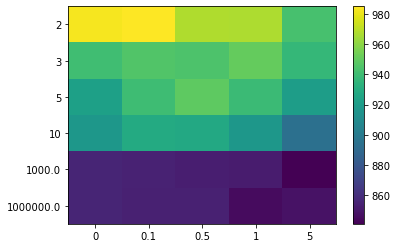

In [26]:
plt.imshow(counts_exp1,aspect='auto')
plt.yticks(range(len(iif_values)),iif_values)
plt.xticks(range(len(dp_values)),dp_values)
plt.colorbar()

## Experiment 2 - QCA, WeightedDEW

In [ ]:
output_folder = Path(os.getcwd(), 'experiment_2')

In [ ]:
for t0 in t0_vals:
    for r in rt_tol_vals:
        if t0 > r:
            # impossible combination
            continue
        print(t0,r)
        out_name = 'WeightedDEW_{}_{}.mzml'.format(t0,r)

        if os.path.isfile(os.path.join(test_path,out_name)):
            print("Already done")
            continue
        
        controller = ExcludingTopNController(ionisation_mode, N, isolation_width, mz_tol, 
                                            r,min_ms1_intensity, exclusion_t_0 = t0, log_intensity = True)

        mass_spec = IndependentMassSpectrometer(ionisation_mode, TopN_QCA_dataset,
                                                ps_frag_QCB,
                                                add_noise=True,
                                               scan_duration_dict=topn_time_dict)

        env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
        env.run()
        
        env.write_mzML(output_folder, out_name)

In [ ]:
counts_exp2 = np.zeros((len(t0_vals),len(rt_tol_vals)))
for i,t0 in enumerate(t0_vals):
    for j,r in enumerate(rt_tol_vals):
        print(t0,r)
        if t0 > r:
            # impossible combination
            counts_exp2[i,j] = np.nan # fix for colour on boxplot
            continue
        fname = 'exlude_{}_{}.mzml'.format(t0,r)
        mz_file = MZMLFile(os.path.join(test_path,fname))
        scans2boxes,boxes2scans = map_boxes_to_scans(mz_file,qca_boxes,half_isolation_window = 0)
        counts_exp2[i,j] = len(boxes2scans)

In [ ]:
plt.imshow(counts_exp2,aspect='auto')
plt.yticks(range(len(iif_values)),iif_values)
plt.xticks(range(len(dp_values)),dp_values)
plt.colorbar()

## Experiment 3 - QCB, SmartROI

In [17]:
output_folder = Path(os.getcwd(), 'experiment_3')

In [ ]:
for iif in iif_values:
    for dp in dp_values:
        print(iif,dp)
        intensity_increase_factor = iif # fragment ROI again if intensity increases 10 fold
        drop_perc = dp/100


        # ROI can also be fragmented again if intensity falls to <1% of the max *since* last fragmentation
        from vimms.Controller import TopN_SmartRoiController
        controller = TopN_SmartRoiController(ionisation_mode, isolation_width, mz_tol, min_ms1_intensity,
                                             min_roi_intensity, min_roi_length, N = N, rt_tol = rt_tol, 
                                             min_roi_length_for_fragmentation = min_roi_length_for_fragmentation,
                                             reset_length_seconds = reset_length_seconds,
                                             intensity_increase_factor = intensity_increase_factor,
                                             drop_perc = drop_perc)

        mass_spec = IndependentMassSpectrometer(ionisation_mode, TopN_QCB_dataset,
                                                ps,
                                                add_noise=True,
                                               scan_duration_dict=roi_time_dict)

        env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
        env.run()
        
        out_name = 'SmartROI_{}_{}.mzml'.format(iif,dp)
        env.write_mzML(output_folder, out_name)

2 0


(1560.430s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.7200000001217/1560 [02:18<00:00, 11.23it/s]


2 0.1


(1560.700s) ms_level=1 N=10 DEW=15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.990000000122/1560 [02:20<00:00, 11.14it/s]


2 0.5


(1560.590s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.8800000001218/1560 [02:14<00:00, 11.60it/s]


2 1


(1560.640s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.9300000001226/1560 [02:35<00:00, 10.04it/s]


2 5


(1560.640s) ms_level=1 N=10 DEW=15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.930000000125/1560 [02:20<00:00, 11.09it/s]


3 0


(1560.470s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.7600000001098/1560 [02:31<00:00, 10.27it/s]


3 0.1


(1560.470s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.7600000001098/1560 [02:13<00:00, 11.65it/s]


3 0.5


(1560.310s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.6000000001093/1560 [02:21<00:00, 11.05it/s]


3 1


(1560.480s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.7700000001107/1560 [02:18<00:00, 11.28it/s]


3 5


(1560.500s) ms_level=1 N=10 DEW=15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1559.7900000001125/1560 [02:14<00:00, 11.60it/s]


5 0


(93.100s) ms_level=1 N=10 DEW=15:   6%|████████▉                                                                                                                                            | 93.09999999999985/1560 [00:07<02:00, 12.18it/s]

In [ ]:
counts_exp3 = np.zeros((len(iif_values),len(dp_values)))
for i,iif in enumerate(iif_values):
    for j,dp in enumerate(dp_values):
        print(iif,dp)
        fname = 'SmartROI_{}_{}.mzml'.format(iif,dp)
        mz_file = MZMLFile(os.path.join(output_folder,fname))
        scans2boxes,boxes2scans = map_boxes_to_scans(mz_file,qcb_boxes,half_isolation_window = 0)
        counts_exp3[i,j] = len(boxes2scans)

In [ ]:
plt.imshow(counts_exp3,aspect='auto')
plt.yticks(range(len(iif_values)),iif_values)
plt.xticks(range(len(dp_values)),dp_values)
plt.colorbar()

## Experiment 4 - QCB, WeightedDEW

In [ ]:
output_folder = Path(os.getcwd(), 'experiment_4')

In [ ]:
for t0 in t0_vals:
    for r in rt_tol_vals:
        if t0 > r:
            # impossible combination
            continue
        print(t0,r)
        out_name = 'WeightedDEW_{}_{}.mzml'.format(t0,r)

        if os.path.isfile(os.path.join(test_path,out_name)):
            print("Already done")
            continue
        
        controller = ExcludingTopNController(ionisation_mode, N, isolation_width, mz_tol, 
                                            r,min_ms1_intensity, exclusion_t_0 = t0, log_intensity = True)

        mass_spec = IndependentMassSpectrometer(ionisation_mode, TopN_QCB_dataset,
                                                ps_frag_QCB,
                                                add_noise=True,
                                               scan_duration_dict=topn_time_dict)

        env = Environment(mass_spec, controller, min_rt, max_rt, progress_bar=True)
        env.run()
        
        env.write_mzML(output_folder, out_name)

In [ ]:
counts_exp4 = np.zeros((len(t0_vals),len(rt_tol_vals)))
for i,t0 in enumerate(t0_vals):
    for j,r in enumerate(rt_tol_vals):
        print(t0,r)
        if t0 > r:
            # impossible combination
            counts_exp4[i,j] = np.nan # fix for colour on boxplot
            continue
        fname = 'exlude_{}_{}.mzml'.format(t0,r)
        mz_file = MZMLFile(os.path.join(test_path,fname))
        scans2boxes,boxes2scans = map_boxes_to_scans(mz_file,qcb_boxes,half_isolation_window = 0)
        counts_exp4[i,j] = len(boxes2scans)

In [ ]:
plt.imshow(counts_exp4,aspect='auto')
plt.yticks(range(len(iif_values)),iif_values)
plt.xticks(range(len(dp_values)),dp_values)
plt.colorbar()

## Reload data and produce final figure (not to be included in example)